# Simulate force profiles for an RF MOT for CaOH

In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue

In [3]:
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

In [4]:
λ = 626e-9
Γ = 2π * 6.4e6 # in units of MHz
m = @with_unit 57 "u"
k = 2π / λ
;

### Load $\tilde{X}(000)$ and $\tilde{A}(000)$ Hamiltonians


In [5]:
HX = load_from_file("CaOH_000_N0to3_Hamiltonian", "..\\..\\..\\QuantumStates\\Hamiltonians\\")
HA = load_from_file("CaOH_A000_J12to52_Hamiltonian", "..\\..\\..\\QuantumStates\\Hamiltonians\\")

HX_N1 = subspace(HX, (N=1,))
HA_J12 = subspace(HA, (Ω=1/2, J=1/2,))

# Add Zeeman term to the X state Hamiltonian
const _μB = (μ_B / h) * (1e-6 * 1e-4)
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
HX_N1 = add_to_H(HX_N1, :B_z, gS * _μB * Zeeman_z)
HX_N1.parameters.B_z = 1e-6

evaluate!(HX_N1); QuantumStates.solve!(HX_N1)
evaluate!(HA_J12); QuantumStates.solve!(HA_J12)

# Convert A states from Hund's case (a) to case (b)
HX_0110 = load_from_file("CaOH_BendingMode_Hamiltonian", "..\\..\\..\\QuantumStates\\Hamiltonians\\")
states_A_J12_caseB = convert_basis(HA_J12.states, HX_0110.basis)
basis_idxs, reduced_A_J12_caseB_basis = states_to_basis(states_A_J12_caseB)
full_basis = [HX_N1.basis; reduced_A_J12_caseB_basis]

for i ∈ eachindex(states_A_J12_caseB)
    states_A_J12_caseB[i].coeffs = states_A_J12_caseB[i].coeffs[basis_idxs]
    states_A_J12_caseB[i].basis = reduced_A_J12_caseB_basis
end

states = [HX_N1.states; states_A_J12_caseB]
for state ∈ states
    state.E *= 1e6
end
;

## Zeeman plot for the $X^2\Sigma^+(N=1)$ state in CaOH

In [6]:
function H_func!(H, scan_values)
    H.parameters.B_z = scan_values[1]
    evaluate!(H)
    QuantumStates.solve!(H)
    for i ∈ eachindex(H.states)
        H.states[i].E *= 1e6
    end
    return nothing
end
;

In [7]:
Bs = (-20:0.01:20)
scan_values = (
    B_z = Bs,
    );
iterator = Iterators.product
@time x, tracked_idxs = scan_parameters(HX_N1, scan_values, iterator, H_func!, H -> energy.(H.states), n_threads=1)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


  2.562253 seconds (7.68 M allocations: 514.634 MiB, 91.51% compilation time)


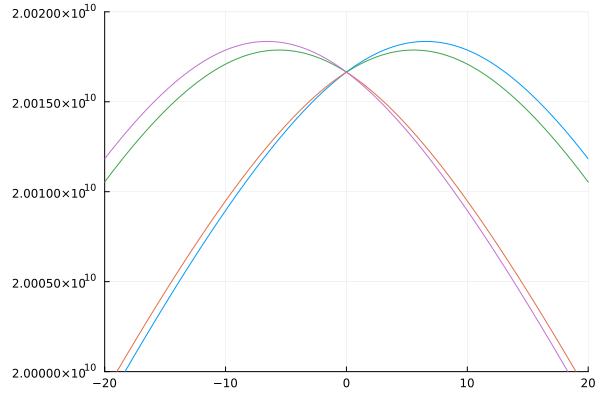

In [8]:
using Plots
plot(Bs, hcat(values(x)...)', legend=nothing)
plot!(xlim=(-20.,20.), ylim=(20000e6,20020e6))

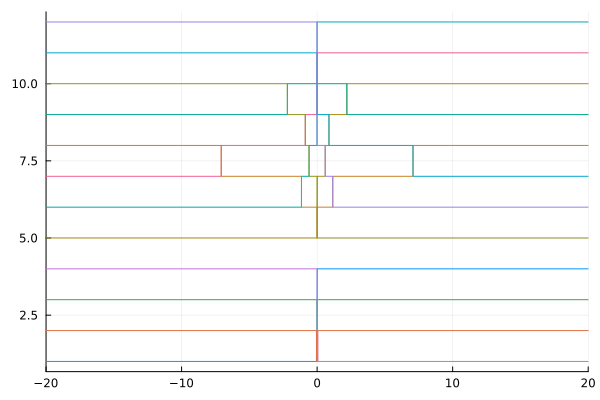

In [9]:
plot(Bs, hcat(values(tracked_idxs)...)', legend=nothing, xlim=(-20,20))

In [10]:
swapping_idxs = Dict{Float64, Vector{Int64}}()
for B ∈ Bs[Bs .>= 0]
    swapping_idxs[B] = collect(1:12)
    if B > 0
        for (i, i_m) ∈ enumerate(tracked_idxs[(-B,)])
            for (j, j_m) ∈ enumerate(tracked_idxs[(+B,)])
                if i_m == j_m
                    swapping_idxs[B][i] = j
                end
            end
        end
    end
end
swapping_idxs = sort(swapping_idxs)
;

### Set up parameters for the simulation

In [11]:
d = zeros(ComplexF64, 16, 16, 3)
d_ge = zeros(ComplexF64, 12, 4, 3)
basis_tdms = get_tdms_two_bases(HX_N1.basis, reduced_A_J12_caseB_basis, TDM)
tdms_between_states!(d_ge, basis_tdms, HX_N1.states, states_A_J12_caseB)
d[1:12, 13:16, :] .= d_ge
;

In [48]:
# Laser parameters
J12_energy = energy(states[1])
J32_energy = energy(states[5])
A_energy = energy(states[13])

# CaOH MOT settings
I_load = 84 / 2 # mW/cm^2, or 33 mW per beam of 1/e² diameter = 1 cm (divide by 2 to account for power split between SR frequencies)
I_ramped = I_load / 11
Isat = π * h * c * (Γ/2π) / (3λ^3)
s_J12 = I_load / Isat
s_J32 = I_load / Isat

# Red-detuned
δJ12 = -2Γ
δJ32 = -2Γ
pol_J12 = σ⁺
pol_J32 = σ⁻

ω_J12 = 2π * (A_energy - J12_energy) + δJ12
ω_J32 = 2π * (A_energy - J32_energy) + δJ32

const f_RF = round(10 * 2π * 1.4e6 / Γ, digits=2)

# Change the polarizations according to a square wave with a frequency of `RF_frq`
ϵ(ϵ1, ϵ2) = t -> Bool(mod(div(f_RF * t, 2π), 2)) ? ϵ1 : ϵ2
# ϵ(ϵ1, ϵ2) = t -> cos(RF_frq * t) * ϵ1 + sin(RF_frq * t) * ϵ2
# ϵ(ϵ1, ϵ2) = t -> ϵ1

ϵ1 = ϵ(rotate_pol(pol_J12, +x̂), rotate_pol(pol_J32, +x̂)); laser1 = Field(+x̂, ϵ1, ω_J12, s_J12)
ϵ2 = ϵ(rotate_pol(pol_J12, -x̂), rotate_pol(pol_J32, -x̂)); laser2 = Field(-x̂, ϵ2, ω_J12, s_J12)
ϵ3 = ϵ(rotate_pol(pol_J12, +ŷ), rotate_pol(pol_J32, +ŷ)); laser3 = Field(+ŷ, ϵ3, ω_J12, s_J12)
ϵ4 = ϵ(rotate_pol(pol_J12, -ŷ), rotate_pol(pol_J32, -ŷ)); laser4 = Field(-ŷ, ϵ4, ω_J12, s_J12)
ϵ5 = ϵ(rotate_pol(pol_J12, +ẑ), rotate_pol(pol_J32, +ẑ)); laser5 = Field(+ẑ, ϵ5, ω_J12, s_J12)
ϵ6 = ϵ(rotate_pol(pol_J12, -ẑ), rotate_pol(pol_J32, -ẑ)); laser6 = Field(-ẑ, ϵ6, ω_J12, s_J12)
lasers_J12 = [laser1, laser2, laser3, laser4, laser5, laser6]

ϵ7  = ϵ(rotate_pol(pol_J32, +x̂), rotate_pol(pol_J12, +x̂)); laser7  = Field(+x̂, ϵ7,  ω_J32, s_J32)
ϵ8  = ϵ(rotate_pol(pol_J32, -x̂), rotate_pol(pol_J12, -x̂)); laser8  = Field(-x̂, ϵ8,  ω_J32, s_J32)
ϵ9  = ϵ(rotate_pol(pol_J32, +ŷ), rotate_pol(pol_J12, +ŷ)); laser9  = Field(+ŷ, ϵ9,  ω_J32, s_J32)
ϵ10 = ϵ(rotate_pol(pol_J32, -ŷ), rotate_pol(pol_J12, -ŷ)); laser10 = Field(-ŷ, ϵ10, ω_J32, s_J32)
ϵ11 = ϵ(rotate_pol(pol_J32, +ẑ), rotate_pol(pol_J12, +ẑ)); laser11 = Field(+ẑ, ϵ11, ω_J32, s_J32)
ϵ12 = ϵ(rotate_pol(pol_J32, -ẑ), rotate_pol(pol_J12, -ẑ)); laser12 = Field(-ẑ, ϵ12, ω_J32, s_J32)
lasers_J32 = [laser7, laser8, laser9, laser10, laser11, laser12]

lasers = [lasers_J12; lasers_J32]
;

### Construct a periodic callback to modify the B field at a fixed rate

In practice, an RF MOT is typically implemented by driving the MOT coils with an ac current at an RF frequency that roughly matches the optical pumping rate of the MOT transition. This is difficult to implement directly, since the states and electric dipole moments will change at each intermittent field value throughout the sinusoidal driving of the coils. The correct way to implement this, of course, would be to include the couplings induced by the magnetic field in the Hamiltonian of the OBE solver. This is not directly straightforward to do, however, because the Hamiltonian of the OBE solver assumes the rotating wave approximation, which requires that the states are eigenstates of the full Hamiltonian (barring the molecule-field interaction, of course). In lieu of this, we therefore model the RF MOT with a B field changing according to a square wave, i.e., the B field simply flips between a negative and positive value at some RF frequency.

#### What happens to the system when the B field is flipped? 
When the B field is flipped, the states are basically transformed as $|F,m\rangle \rightarrow (-1)^{F-m} |F,-m\rangle$, which is equivalent to rotating the states from the quantization axis $+\hat{z}$ to $-\hat{z}$. (For a "real" RF MOT with an ac current, non-adiabatic transitions likely scramble populations nearly fully as the magnetic field goes through zero.) The simulation does not care about the exact nature of the states, so all that needs to be changed to make the B field "flip" is the energies of the states. The transition moments for the states remain the same due to symmetry.

In [49]:
function flip_Bfield!(integrator)
    p = integrator.p
    # "Flip" the energy of the states
    p.ω[1:12] .= p.ω[p.extra_p.swapping_idxs[p.extra_p.B]]
    return nothing
end
flip_Bfield_cb = PeriodicCallback(flip_Bfield!, 2π / f_RF)
;

In [50]:
# Set initial conditions
particle = Particle()
particle.r0 = (0.0, 0.0, 0.0)
particle.v = (0.0, 0.0, 0.0)

ρ0 = zeros(ComplexF64, length(states), length(states)) # Use a static array for this??? Might be better...
ρ0[1,1] = 1.0

freq_res = 1e-2

const B_field_conversion = (Γ / (_μB * 1e6))

using StaticArrays
B = 0. #HX_N1.parameters.B_z
extra_p = (swapping_idxs=swapping_idxs, B=B)
@time p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

p.B = (0., 0., 0.) ./ (Γ / (_μB * 1e6))
p.r0 = (0., 0., 0.) .* 2π
p.v = (0., 0., 5.) ./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)
;

  0.735775 seconds (1.87 M allocations: 95.617 MiB, 99.37% compilation time)


In [51]:
# using BenchmarkTools
# dρ = deepcopy(ρ0)
# @time ρ!(dρ, ρ0, p, 0.3)
# @btime ρ!($dρ, $ρ0, $p, 0.3)

In [52]:
t_end = 5p.period+1
tspan = (0., t_end)
force_cb = PeriodicCallback(reset_force!, p.period)
cbs = CallbackSet(flip_Bfield_cb, force_cb)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, callback=cbs)
;

In [53]:
prob.p.force_last_period = (0, 0, 0)
sort!(prob.p.ω)
@time sol = DifferentialEquations.solve(prob, DP5(), abstol=1e-6)
;

  9.722082 seconds (16.07 M allocations: 2.256 GiB, 14.61% gc time, 89.97% compilation time)


In [54]:
sol.t[end], t_end

(3142.5926535897934, 3142.5926535897934)

In [55]:
using Plots
plot_us = sol.u
plot_ts = sol.t

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

In [56]:
p.force_last_period

3-element SVector{3, Float64} with indices SOneTo(3):
  5.143143279889479e-7
 -5.656780372929721e-5
  7.306989352233106e-5

## Force versus velocity

In [57]:
function prob_func!(prob, scan_values, i)
    # Update velocity and position
    prob.p.v .= sample_direction(scan_values.v[i])
    prob.p.v .= round_vel(prob.p.v, prob.p.freq_res)    
    prob.p.r0 .= rand(uniform_dist, 3)
    return prob
end
function param_func(p, scan_values, i)
    return scan_values.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    return (f ⋅ p.v) / norm(p.v)
end
;

In [58]:
freq_res = 1e-2
B = 2.0
extra_p = (swapping_idxs=swapping_idxs, B=B)
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 3p.period+1; tspan = (0., t_end)
# prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false, callback=flip_Bfield_cb)

n_samples = 300

prob.p.B .= (0.0, 0.0, 0.0)
vs = repeat([collect(0:0.2:2.0); collect(2.2:0.3:4.5); collect(5:1:10)], n_samples) ./ (Γ / k)
# vs = repeat(collect(0:0.2:4), n_samples) ./ (Γ / k)

scan_values = (v = vs,)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:02:44


164.566658 seconds (8.82 M allocations: 1.683 GiB, 1.46% compilation time)


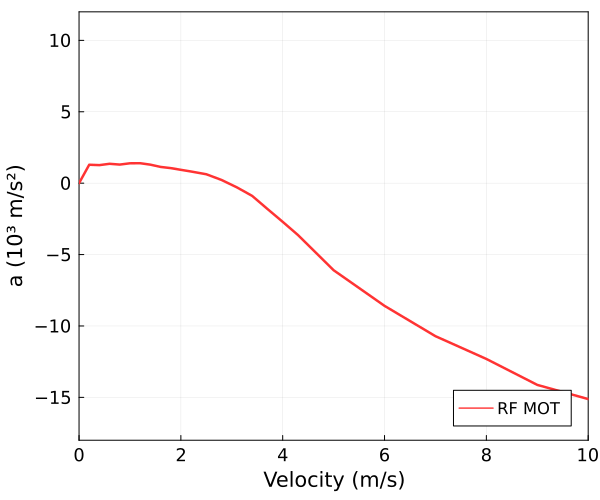

In [59]:
@time scan_params, forces = force_scan(prob, scan_values, prob_func!, param_func, output_func);
vs, averaged_forces = average_forces(scan_params, forces)
averaged_forces[1] = 0.0
plot(vs .* (Γ / k), (1e-3 * ħ * k * Γ / m) .* averaged_forces,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)", 
    framestyle=:box,
    ylim=(-18,12),
    xlim=(0,10),
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    label="RF MOT",
    size=(600,500),
    color=RGB(1,0.2,0.2),
    legend=:bottomright)
# plot!(vs .* (Γ / k),  (1e-3 * ħ * k * Γ / m) .* blue_DC_forces, linewidth=2.5, label="(blue) DC MOT", color=RGB(0.2,0.2,1))

In [60]:
blue_DC_forces = [0.0, -0.004410607546262044, -0.005581264823040229, -0.005799713010807148, -0.004699058294515393, -0.0019089558974122267, -0.0015379106948589084, -0.0011643360088237058, 0.0007092155239621717, 0.002403532957884682, 0.004708772859856131, 0.005819378082001024, 0.0069672371201304735, 0.008172323976287154, 0.010079429742278729, 0.011404216983319455, 0.01162643592744097, 0.011323837962029298, 0.010787038279521802, 0.00780300458738963, 0.00439792740316883, 0.0027315812263389956, 0.0018059256942329527, 0.001282560463723427, 0.0009195766669289975];

## Force versus magnetic field

In [61]:
function prob_func!(prob, scan_values, i)
    p = prob.p

    # Solve Hamiltonian for new `Bz` value (this is expensive, so only do it if the value has changed)
    Bz = scan_values.Bz[i]
    if p.extra_p.HX_N1.parameters.B_z != Bz
        # prob.p.B .= (0.0, 0.0, Bz)
        p.B .= (0., 0., 0.)
        p.extra_p.HX_N1.parameters.B_z = Bz * (p.Γ / (_μB * 1e6))
        evaluate!(p.extra_p.HX_N1)
        QuantumStates.solve!(p.extra_p.HX_N1)
        for i ∈ eachindex(p.extra_p.HX_N1.states)
            p.extra_p.HX_N1.states[i].E *= 1e6
        end

        # Update TDMs
        tdms_between_states!(p.extra_p.d_ge, p.extra_p.basis_tdms, p.extra_p.HX_N1.states, p.extra_p.states_A_J12_caseB)
        p.d[1:12, 13:16, :] .= p.extra_p.d_ge
        
        states′ = [p.extra_p.HX_N1.states; p.extra_p.states_A_J12_caseB]

        extra_p = (HX_N1=p.extra_p.HX_N1, states_A_J12_caseB=p.extra_p.states_A_J12_caseB, d_ge=p.extra_p.d_ge, 
            swapping_idxs=p.extra_p.swapping_idxs, B=p.extra_p.HX_N1.parameters.B_z)
        new_p = obe(
            p.ρ0, p.particle, states′, p.fields, p.d, p.d_m, true, true, p.λ, p.Γ, p.freq_res, extra_p
        )
    end
    
    # Update velocity, position, and "reset" the frequencies of the lasers
    # (Technically, we're only overwriting the laser frequencies in `new_p` here because `obe` changes them when there's no need to 
    # -- will need to shore up how this is handled.)
    new_p.v .= sample_direction(0.1)
    new_p.r0 .= rand(uniform_dist, 3)
    # new_p.v .= (0., 0., 0.) #scan_values.v[i]
    # new_p.r0 .= scan_values.r[i]
    new_p.fields.ω .= p.fields.ω
    sort!(new_p.ω)
    
    # Ensure that frequencies and velocities are rounded
    round_params(new_p)
    
    return remake(prob, p=new_p)
end
function param_func(p, scan_values, i)
    return scan_values.Bz[i]
end
function output_func(p, sol)
    f = p.force_last_period
    return f[3] #(f ⋅ p.v) / norm(p.v)
end
;

In [62]:
freq_res = 1e-2
extra_p = (basis_tdms=basis_tdms, HX_N1=HX_N1, states_A_J12_caseB=states_A_J12_caseB, d_ge=d_ge, swapping_idxs=swapping_idxs, B=0.)
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 10p.period+1; tspan = (0., t_end)
# prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false, callback=flip_Bfield_cb)

Bzs = (0:3:15) ./ (Γ / (_μB * 1e6))
# rs = vec([[rx, ry, rz] for rx in (0:1/16:0.95), ry in (0:1/16:0.95), rz in (0:1/16:0.95)])
# vs = [0.0]
# iterator = Iterators.product(Bzs, rs, vs)

n_samples = 1000

scan_values = (Bz = repeat(Bzs, n_samples),)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:05:14m


314.152148 seconds (32.58 M allocations: 4.968 GiB, 0.62% gc time, 3.75% compilation time)


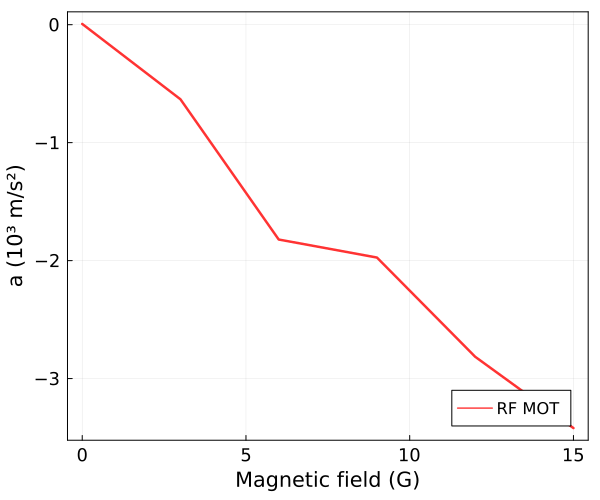

In [63]:
@time scan_params, forces_magnetic = force_scan(prob, scan_values, prob_func!, param_func, output_func)
Bzs, averaged_forces = average_forces(scan_params, forces_magnetic)
plot(Bzs .* (Γ / (_μB * 1e6)), (1e-3 * ħ * k * Γ / m) .* averaged_forces, 
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(-3,0),
    label="RF MOT",
    size=(600,500),
    color=RGB(1,0.2,0.2),
    legend=:bottomright)
# plot!(Bzs .* (Γ / (_μB * 1e6)), (1e-3 * ħ * k * Γ / m) .* blue_detuned_mag_forces, linewidth=2.5, label="(blue) DC MOT", color=RGB(0.2,0.2,1))

In [46]:
blue_detuned_mag_forces = [0.00016507013082142055, -0.0007067876754985982, -0.0005753511727291065, 9.083755225758028e-5, -0.0010861271503461141, -0.0025805154405650283, -0.004311359570523475, -0.00562847843882797, -0.005856678113010501, -0.00569716432287101, -0.005466530412240388, -0.004964226636210861, -0.005142811753209091, -0.0035084533983958184, -0.0029291549924079447, -0.002831271478612264, -0.0015127576026799869, -0.0013993356769486794, -0.0012734523578280177, -0.0008672793234566397, -0.0006116808381690609, -0.00030337741153799993, -0.00043210096936767856, -0.000588416963440238, -0.0009681342498859899, -0.0010759266257680167, -0.0006685668564877023, -0.0008137113964627089, -0.0008862110712387968, -0.0009190918504143307, -0.000881645632255989];

Progress: 100%|█████████████████████████████████████████| Time: 0:02:17


137.244964 seconds (3.55 M allocations: 1.536 GiB)


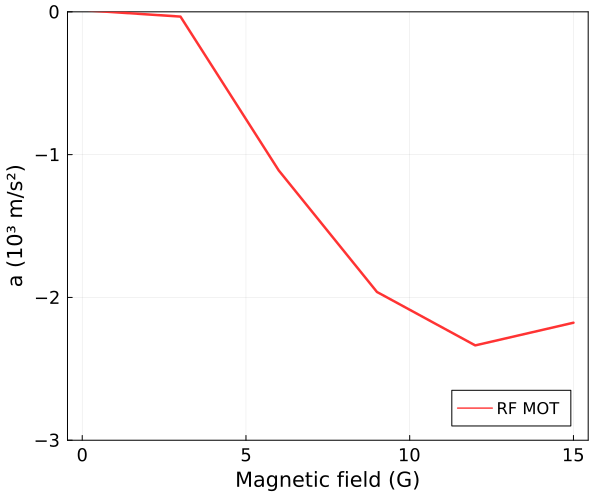

In [47]:
@time scan_params, forces_magnetic = force_scan(prob, scan_values, prob_func!, param_func, output_func)
Bzs, averaged_forces = average_forces(scan_params, forces_magnetic)
plot(Bzs .* (Γ / (_μB * 1e6)), (1e-3 * ħ * k * Γ / m) .* averaged_forces, 
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    ylim=(-3,0),
    label="RF MOT",
    size=(600,500),
    color=RGB(1,0.2,0.2),
    legend=:bottomright)
# plot!(Bzs .* (Γ / (_μB * 1e6)), (1e-3 * ħ * k * Γ / m) .* blue_detuned_mag_forces, linewidth=2.5, label="(blue) DC MOT", color=RGB(0.2,0.2,1))